# Data Preparation

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/processed/pdf_paragraphs.csv')
df.head()

,document,page,text,cleaned_text
0,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,purpose this article provides guidance regardi...
1,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,definitions artificial intelligence ai machine...
2,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,artificial intelligence system any system soft...
3,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,compliant artificial intelligence platform gen...
4,SaltLakeCity.pdf,1,ARTICLE E. USE OF GENERATIVE ARTIFICIAL INTELL...,generative artificial intelligence branch of a...


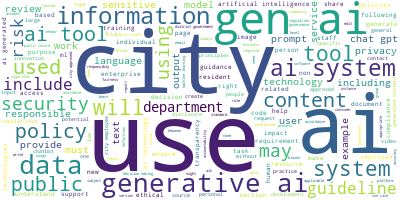

In [3]:
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['cleaned_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [4]:

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# 1) Build stopwords (toggle ACRONYMS_OPTIONAL as you prefer)
CITY_STOP = {'boston','cambridge','san','francisco','long','beach','lebanon','tempe','jose','dc','washington','district','columbia','octo','itd','tid','doit','city','county','department','division','office','agency','bureau'}
POLICY_BOILERPLATE = {'policy','policies','guidelines','principles','definitions','purpose','scope','procedures','glossary','references','contact','versioning','effective','adopted','date','chapter','section','appendix','document','documents','table','contents','page','version'}
DATES_ADMIN = {'january','february','march','april','may','june','july','august','september','october','november','december','2023','2024','2025','2026','v1','v1.1','v1.2','v1.3'}
TOOLS_VENDORS = {'copilot','microsoft','chatgpt','gemini','claude','snowflake','adobe','teams','sharepoint'}
ACRONYMS_OPTIONAL = {'22j','pra','wisp','baa','phi','pii'}  # remove from union to keep these tokens
#GENERAL_EXTRAS = {'use','using','used','users','staff','employees','tools','tool','services','work','content','information','data','generated','review','edit','ensure','include','includes','including','public','private','sensitive','confidential','approved','under','available','provide','provides','support','requirements','risk','risks','security','privacy'}

DOMAIN_STOPWORDS = CITY_STOP | POLICY_BOILERPLATE | DATES_ADMIN | TOOLS_VENDORS | ACRONYMS_OPTIONAL #| GENERAL_EXTRAS
STOPWORDS = set(ENGLISH_STOP_WORDS) | DOMAIN_STOPWORDS


In [5]:
# 2) Vectorize (bigrams + hyphen-aware tokens)
vectorizer = CountVectorizer(
    stop_words=list(STOPWORDS),
    ngram_range=(1, 2),
    max_df=0.90,
    min_df=2,
    token_pattern=r'(?u)\b[a-z][a-z\-]{2,}\b'
)
X = vectorizer.fit_transform(df['cleaned_text'])
terms = vectorizer.get_feature_names_out()


# 2. LDA

In [6]:

n_topics = 10
lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='batch',
    max_iter=30,
    random_state=42
).fit(X)

def print_topics(model, feature_names, n_top_words=15):
    for idx, topic in enumerate(model.components_):
        top = topic.argsort()[-n_top_words:][::-1]
        print(f"Topic {idx:02d}: " + ", ".join(feature_names[i] for i in top))


print_topics(lda, terms, n_top_words=5)

Topic 00: use, intelligence, artificial intelligence, artificial, information
Topic 01: data, chat, content, additional, uses
Topic 02: use, gen, tools, public, systems
Topic 03: review, technology, use, tools, responsible
Topic 04: systems, content, number, use, guidance
Topic 05: data, decision, making, decision making, review
Topic 06: generative, data, chat, gpt, learning
Topic 07: generative, use, content, using, help
Topic 08: information, use, systems, data, chat
Topic 09: information, public, data, sensitive, government


In [7]:
import pandas as pd
from collections import Counter
import re

def suggest_stopwords(texts, top_k=200):
    #    # crude unigram tokenizer aligned with token_pattern
    uni = Counter()
    for t in texts:
        for w in re.findall(r'[a-z][a-z\-]{2,}', t.lower()):
            uni[w] += 1
    # Return candidates that are high-frequency and uninformative by inspection
    return [w for w, c in uni.most_common(top_k)]

candidates = suggest_stopwords(df['cleaned_text'], top_k=200)


In [8]:
candidates

['the',
 'and',
 'for',
 'city',
 'use',
 'that',
 'information',
 'with',
 'you',
 'data',
 'generative',
 'gen',
 'systems',
 'are',
 'tools',
 'this',
 'public',
 'can',
 'not',
 'content',
 'technology',
 'will',
 'policy',
 'these',
 'any',
 'from',
 'used',
 'chat',
 'should',
 'security',
 'other',
 'may',
 'using',
 'responsible',
 'your',
 'human',
 'guidelines',
 'when',
 'system',
 'review',
 'our',
 'such',
 'privacy',
 'must',
 'gpt',
 'employees',
 'generated',
 'all',
 'sensitive',
 'work',
 'department',
 'their',
 'intelligence',
 'including',
 'staff',
 'language',
 'include',
 'provide',
 'risks',
 'risk',
 'users',
 'tool',
 'have',
 'into',
 'text',
 'artificial',
 'example',
 'training',
 'models',
 'approved',
 'they',
 'government',
 'new',
 'ensure',
 'make',
 'model',
 'but',
 'access',
 'support',
 'code',
 'services',
 'more',
 'copilot',
 'enterprise',
 'prompt',
 'guidance',
 'technologies',
 'ethical',
 'district',
 'resources',
 'outputs',
 'uses',
 'lea

In [9]:
# --- Build stopwords ---
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Your list (paste as-is; dedup happens automatically via set)
INCLUDE = {
    'the','and','for','city','use','that','information','with','you',
    'generative','gen','systems','are','tools','this','can','not',
    'content','technology','will','policy','these','any','from','used','chat',
    'should','other','may','using','your',
    'guidelines','when','system','our','such','must','gpt',
    'generated','all', 'work','department','their',
    'intelligence','including','staff','language','include','provide',
    'users','tool','have','into','artificial','example','training',
    'models','they','government','new','ensure','make','model','but',
    'services','more','copilot',
    'guidance','technologies','district','resources','outputs','uses',
    'learning','based','section','potential','while',
    'its','also','was','large', 'policies','how','about',
    'includes','non', 'related','understand',
    'machine','through','generate','shall','fact','page',
    'document','microsoft','share','following','check','which','some','people','purpose','making','request','would',
    'person','name','out','development','only','output','before',
    'protected','general','where','practices','without','contact','tasks',
    'specific','process','date','cases','what','create',
    'write','lebanon','software','limited',
    'processes','impact','usage','has',
    'does','laws','could','required','version','itd','google','within','platforms',
    'might','follow','being',"salt", "lake", "salt lake", "summary"
}

STOPWORDS = set(ENGLISH_STOP_WORDS) | INCLUDE  # final stopword set

# --- Vectorizer tuned for policy text ---
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    stop_words=list(STOPWORDS),
    ngram_range=(1, 3),                 # keep bigrams (e.g., "public records", "data protection")
    max_df=0.90,                        # mute ultra-common terms across corpus
    min_df=2,                            # require term appears in >= 2 docs/pages
    token_pattern=r'(?u)\b[a-z][a-z\-]{2,}\b'  # >=3 chars, allows hyphenated tokens
)

X = vectorizer.fit_transform(df['cleaned_text'])  # df should contain your cleaned text
terms = vectorizer.get_feature_names_out()

print("Vocab size:", len(terms))
print("Sample terms:", terms[:30])


Vocab size: 2039
Sample terms: ['ability' 'ability age' 'ability age religious' 'ability learn' 'able'
 'abstract' 'abstract perceptions' 'abstract perceptions analysis'
 'acceptable' 'access' 'access code' 'access code personal'
 'access disclosure' 'access financial' 'access financial account'
 'access public' 'accessibility' 'accessible' 'accordance'
 'accordance applicable' 'accordance security' 'account' 'account number'
 'account number credit' 'account obtained' 'account obtained publicly'
 'accountability' 'accountable' 'accounts' 'accounts providing']


In [10]:
n_topics = 8  # start 8–15 for policy corpora; tune based on coherence
lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='batch',
    max_iter=30,
    random_state=42
).fit(X)


print_topics(lda, terms, n_top_words=5)

Topic 00: risks, violations, bias, drafting, employees
Topic 01: data, security, approved, prohibited, responsible
Topic 02: public, records, number, public records, access
Topic 03: data, responsible, risk, public, sensitive
Topic 04: data, public, requirements, decisions, support
Topic 05: review, data, human, sensitive, enterprise
Topic 06: text, prompt, principles, data, patterns
Topic 07: data, privacy, employees, transparency, scope


In [11]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

Computing scores...
  n_topics=3... perplexity=1873.0839
  n_topics=4... perplexity=1873.0839
  n_topics=4... perplexity=1980.2663
  n_topics=5... perplexity=1980.2663
  n_topics=5... perplexity=2088.1610
  n_topics=6... perplexity=2088.1610
  n_topics=6... perplexity=2181.8160
  n_topics=7... perplexity=2181.8160
  n_topics=7... perplexity=2107.7783
  n_topics=8... perplexity=2107.7783
  n_topics=8... perplexity=2232.7975
  n_topics=9... perplexity=2232.7975
  n_topics=9... perplexity=2243.5033
  n_topics=10... perplexity=2243.5033
  n_topics=10... perplexity=2215.0519
  n_topics=11... perplexity=2215.0519
  n_topics=11... perplexity=2284.8029
  n_topics=12... perplexity=2284.8029
  n_topics=12... perplexity=2349.9751
  n_topics=13... perplexity=2349.9751
  n_topics=13... perplexity=2351.5438
  n_topics=14... perplexity=2351.5438
  n_topics=14... perplexity=2388.6897
  n_topics=15... perplexity=2388.6897
  n_topics=15... perplexity=2551.2640

Optimal number of topics: 3 (perplexity=18

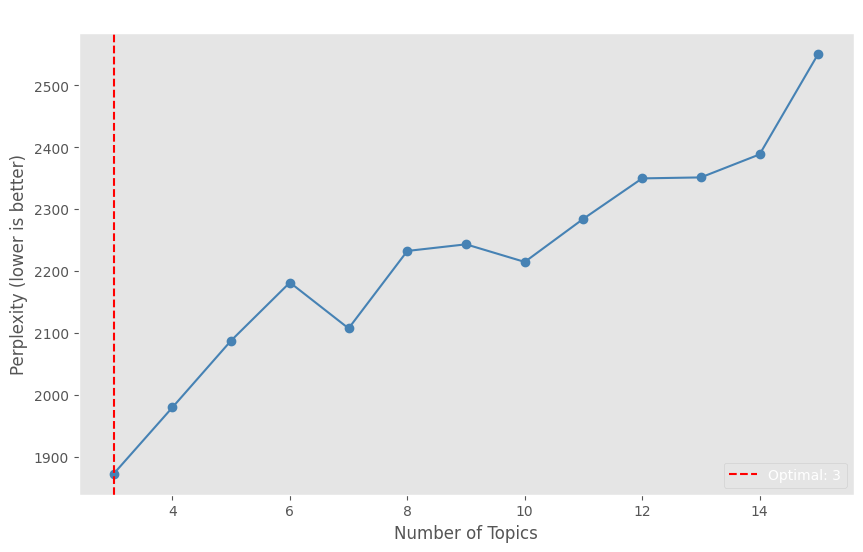


Using LDA with 3 topics:
Topic 00: review, data, text, prompt, prompts, human, risks, help, responsible, images
Topic 01: data, security, privacy, sensitive, responsible, risk, employees, approved, enterprise, health
Topic 02: public, human, ethical, transparency, records, sensitive, responsible, code, available, risk


In [12]:
from gensim import corpora, models
from gensim.models import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt

# Create gensim dictionary and corpus
dictionary = corpora.Dictionary()
dictionary.id2token = {i: term for i, term in enumerate(terms)}
dictionary.token2id = {term: i for i, term in enumerate(terms)}

# Convert sparse X to list of tuples (word_id, freq) for each doc
corpus = []
for doc_idx in range(X.shape[0]):
    doc = []
    for word_idx, freq in zip(X[doc_idx].indices, X[doc_idx].data):
        doc.append((word_idx, int(freq)))
    corpus.append(doc)

# Test different topic numbers using perplexity (lower is better)
topic_range = range(3, 16)  # test 3 to 15 topics
perplexity_scores = []
models_list = []

print("Computing scores...")
for n_topics in topic_range:
    print(f"  n_topics={n_topics}...", end=" ")
    lda_temp = LatentDirichletAllocation(
        n_components=n_topics,
        learning_method='batch',
        max_iter=30,
        random_state=42
    ).fit(X)
    
    # Compute perplexity (lower is better)
    perplexity = lda_temp.perplexity(X)
    perplexity_scores.append(perplexity)
    models_list.append(lda_temp)
    print(f"perplexity={perplexity:.4f}")

# Find optimal number of topics (lowest perplexity)
best_idx = np.argmin(perplexity_scores)
optimal_n_topics = list(topic_range)[best_idx]
best_perplexity = perplexity_scores[best_idx]

print(f"\nOptimal number of topics: {optimal_n_topics} (perplexity={best_perplexity:.4f})")

# Plot perplexity scores
plt.figure(figsize=(10, 6))
plt.plot(list(topic_range), perplexity_scores, marker='o', color='steelblue')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity (lower is better)')
plt.title('LDA Perplexity by Number of Topics')
plt.axvline(x=optimal_n_topics, color='r', linestyle='--', label=f'Optimal: {optimal_n_topics}')
plt.legend()
plt.grid()
plt.show()

# Use the best model
lda = models_list[best_idx]
print(f"\nUsing LDA with {optimal_n_topics} topics:")
print_topics(lda, terms, n_top_words=10)

In [13]:
optimal_n_topics = 5
optimal_n_topics

5

# 3. Vizualization

In [14]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import os

# Build gensim LDA model from scratch (required for pyLDAvis)
gensim_dictionary = corpora.Dictionary()
gensim_dictionary.id2token = {i: term for i, term in enumerate(terms)}
gensim_dictionary.token2id = {term: i for i, term in enumerate(terms)}

# Convert to gensim corpus format
gensim_corpus = []
for doc_idx in range(X.shape[0]):
    doc = []
    for word_idx, freq in zip(X[doc_idx].indices, X[doc_idx].data):
        doc.append((word_idx, int(freq)))
    gensim_corpus.append(doc)

print(f"Training Gensim LDA with {optimal_n_topics} topics for visualization...")
gensim_lda = models.LdaMulticore(
    corpus=gensim_corpus,
    id2word=gensim_dictionary,
    num_topics=optimal_n_topics,
    workers=2,
    #passes=30,
    per_word_topics=True,
    random_state=42
)

vis = gensimvis.prepare(gensim_lda, gensim_corpus, gensim_dictionary,sort_topics=False)

# Save interactive HTML
output_path = '../visualizations/lda_interactive.html'
os.makedirs('../visualizations', exist_ok=True)
pyLDAvis.save_html(vis, output_path)

vis

Training Gensim LDA with 5 topics for visualization...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.088425 -0.033563       1        1  14.839170
1      0.017032  0.102197       2        1  24.682403
2     -0.023406 -0.017831       3        1  18.785309
3     -0.002226 -0.041824       4        1  21.458846
4     -0.079825 -0.008978       5        1  20.234273, topic_info=              Term        Freq       Total Category  logprob  loglift
464           data  113.000000  113.000000  Default  30.0000  30.0000
910          human   39.000000   39.000000  Default  29.0000  29.0000
125       approved   23.000000   23.000000  Default  28.0000  28.0000
1479        public   79.000000   79.000000  Default  27.0000  27.0000
895           help   14.000000   14.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1910  transparency    4.338020   19.122818   Topic5  -5.9282   0.1143
1469    protection 

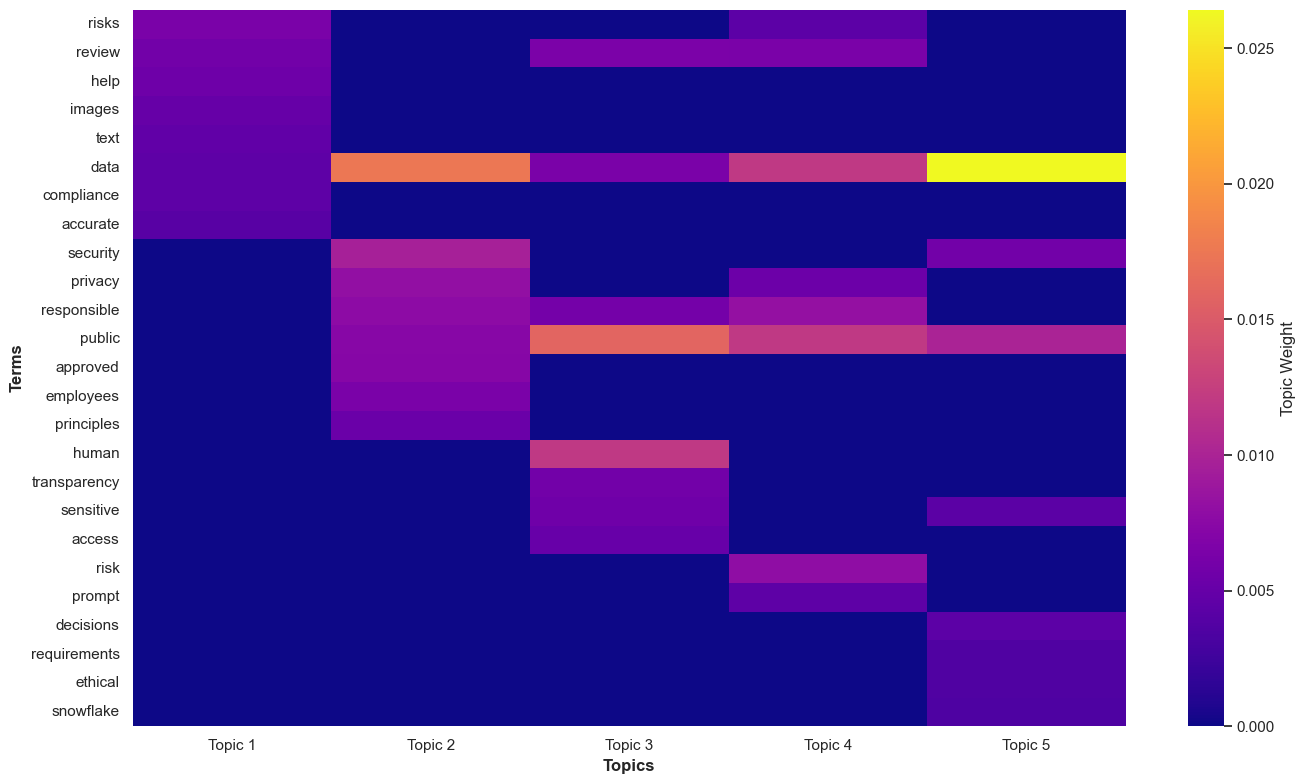

In [ ]:
import seaborn as sns

sns.set_theme()


fig, axes = plt.subplots(figsize=(14, 8))

# Extract top 8 terms per topic from gensim model
topics_terms = {}
for idx in range(optimal_n_topics):
    terms_dist = gensim_lda.show_topic(idx, topn=8)
    topics_terms[f'Topic {idx + 1}'] = {term: float(prob) for term, prob in terms_dist}

# Create heatmap data
heatmap_df = pd.DataFrame(topics_terms).fillna(0)

sns.heatmap(heatmap_df, 
            cmap='plasma',
            cbar_kws={'label': 'Topic Weight'}, 
            ax=axes)

axes.set_xlabel('Topics', fontsize=12, fontweight='bold')
axes.set_ylabel('Terms', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visualizations/topic_terms_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


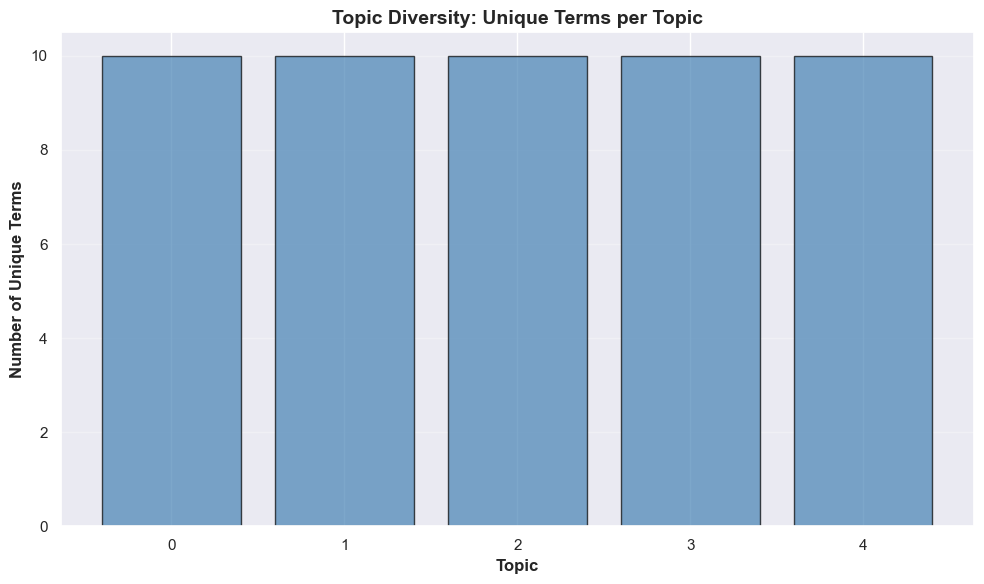

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

topic_sizes = [len(gensim_lda.get_topic_terms(i)) for i in range(optimal_n_topics)]

ax.bar(range(optimal_n_topics), topic_sizes, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Topic', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Unique Terms', fontsize=12, fontweight='bold')
ax.set_title('Topic Diversity: Unique Terms per Topic', fontsize=14, fontweight='bold')
ax.set_xticks(range(optimal_n_topics))
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()

#plt.savefig('../visualizations/topic_diversity.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
if getattr(lda, "n_components", None) != optimal_n_topics:
    lda = LatentDirichletAllocation(
        n_components=optimal_n_topics,
        learning_method='batch',
        max_iter=30,
        random_state=42
    ).fit(X)

doc_topic_dist = lda.transform(X)  # shape: (n_documents, n_topics)

df_with_topics = df.copy()
df_with_topics['document'] = df_with_topics['document'].str.strip('.pdf')
df_with_topics['doc_id'] = range(len(df))

# Add topic distribution for each paragraph
for topic_idx in range(optimal_n_topics):
    df_with_topics[f'topic_{topic_idx}_prob'] = doc_topic_dist[:, topic_idx]

# Aggregate by document: average topic distribution per document
doc_topic_agg = df_with_topics.groupby('document')[[f'topic_{i}_prob' for i in range(optimal_n_topics)]].mean()
doc_topic_agg.columns = [f'Topic {i +1}' for i in range(optimal_n_topics)]

print("Document-Topic Distribution (Aggregated):")
print(doc_topic_agg)
print(f"\nShape: {doc_topic_agg.shape} (documents × topics)")

Document-Topic Distribution (Aggregated):
               Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
document                                                      
Boston        0.244824  0.180961  0.196761  0.218271  0.159183
Cambridge     0.240257  0.243144  0.239411  0.119231  0.157958
DC            0.129696  0.224689  0.204225  0.211297  0.230092
Lebanon       0.166958  0.179048  0.257995  0.194163  0.201837
LongBeach     0.142149  0.268249  0.142346  0.275410  0.171846
SF            0.262266  0.158078  0.196962  0.187995  0.194700
SaltLakeCity  0.184347  0.144297  0.160123  0.364940  0.146292
SanJose       0.135518  0.224730  0.121389  0.272260  0.246102
Tempe         0.178671  0.152757  0.230920  0.182724  0.254928

Shape: (9, 5) (documents × topics)


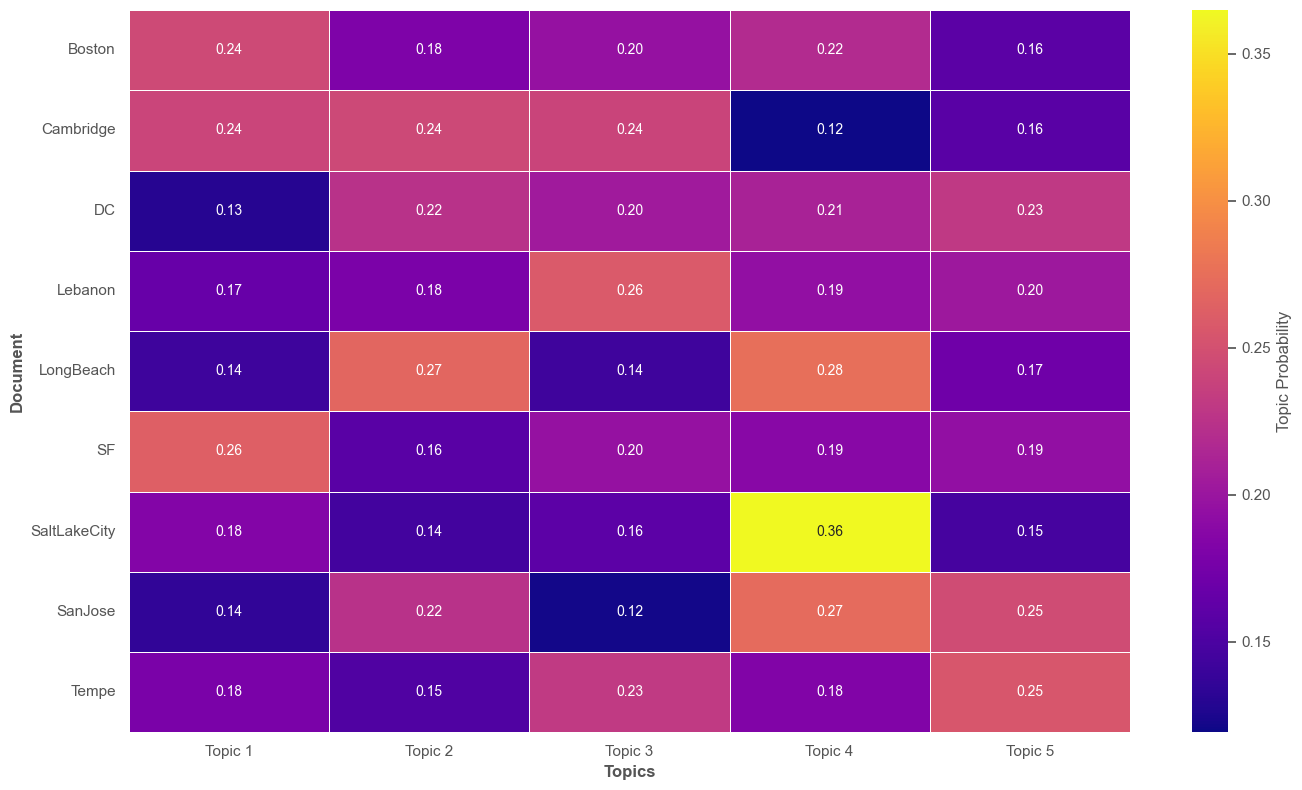

In [19]:
# Shows topic composition for each document
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(14, 8))

# Normalize for heatmap (0-1 scale)
sns.heatmap(
    doc_topic_agg,
    cmap='plasma',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Topic Probability'},
    linewidths=0.5,
    ax=ax
)
#ax.set_title('Topic Distribution Across Documents', fontsize=14, fontweight='bold')
ax.set_xlabel('Topics', fontsize=12, fontweight='bold')
ax.set_ylabel('Document', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visualizations/doc_topic_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

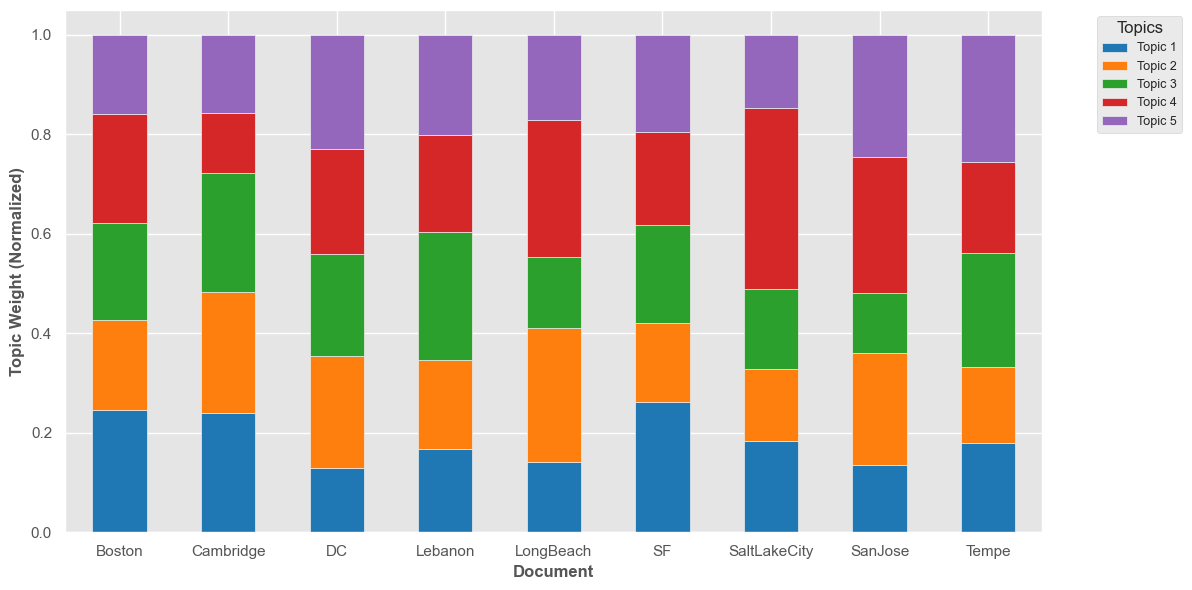

In [20]:
# Shows relative topic composition per document (normalized)

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(12, 6))

# Normalize rows to sum to 1 for stacked bar chart
doc_topic_normalized = doc_topic_agg.div(doc_topic_agg.sum(axis=1), axis=0)

# Build palette using the first 6 tab10 colors (blue through brown)
base_colors = plt.get_cmap('tab10').colors[:6]
palette = (list(base_colors) * ((optimal_n_topics + 5) // 6))[:optimal_n_topics]

doc_topic_normalized.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap=ListedColormap(palette),
)

ax.set_xlabel('Document', fontsize=12, fontweight='bold')
ax.set_ylabel('Topic Weight (Normalized)', fontsize=12, fontweight='bold')

ax.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../visualizations/doc_topic_stacked.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/lf/1r0cw2qs3pq870f2x7yb20w40000gn/T/ipykernel_36812/851586852.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  doc_colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(doc_topic_agg)))


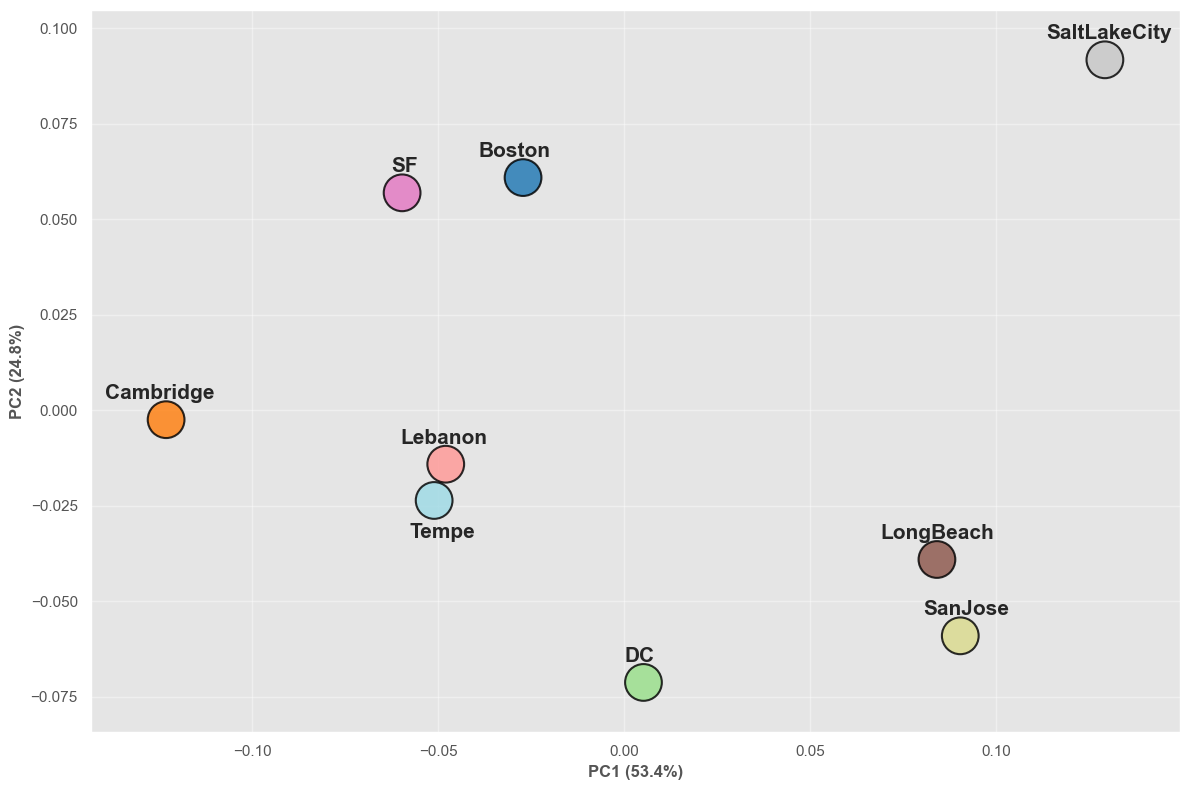

In [21]:
# Visualize documents in 2D space based on topic similarity

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute document similarity using cosine distance on topic distributions
doc_similarity = cosine_similarity(doc_topic_agg)

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
doc_topic_2d = pca.fit_transform(doc_topic_agg)

# Build non-repeating colors across documents (tab20 sampled uniquely)
doc_colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(doc_topic_agg)))

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    doc_topic_2d[:, 0],
    doc_topic_2d[:, 1],
    s=700,
    alpha=0.82,
    color=doc_colors,
    edgecolors='black',
    linewidth=1.5
)

ax.margins(0.08)
jitters = np.linspace(-6, 6, len(doc_topic_agg))  # symmetric horizontal offsets
for idx, doc_name in enumerate(doc_topic_agg.index):
    name_lower = doc_name.lower()
    is_tempe = name_lower.startswith('tempe')
    is_salt_lake = name_lower.startswith('salt lake')

    offset_y = -16 if is_tempe else 12
    va_align = 'top' if is_tempe else 'bottom'

    # Shift Salt Lake City label slightly left to clear the marker
    x_offset = jitters[idx] - 10 if is_salt_lake else jitters[idx]

    ax.annotate(
        doc_name,
        (doc_topic_2d[idx, 0], doc_topic_2d[idx, 1]),
        xytext=(x_offset, offset_y),
        textcoords='offset points',
        ha='center',
        va=va_align,
        fontsize=15,
        fontweight='bold',
        clip_on=True
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12, fontweight='bold')
ax.grid(alpha=0.4)
plt.tight_layout()

plt.savefig('../visualizations/doc_similarity_pca.png', dpi=300, bbox_inches='tight')

plt.show()

In [33]:
doc_topic_agg

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
document,,,,,
Boston,0.244824,0.180961,0.196761,0.218271,0.159183
Cambridge,0.240257,0.243144,0.239411,0.119231,0.157958
DC,0.129696,0.224689,0.204225,0.211297,0.230092
Lebanon,0.166958,0.179048,0.257995,0.194163,0.201837
LongBeach,0.142149,0.268249,0.142346,0.275410,0.171846
SF,0.262266,0.158078,0.196962,0.187995,0.194700
SaltLakeCity,0.184347,0.144297,0.160123,0.364940,0.146292
SanJose,0.135518,0.224730,0.121389,0.272260,0.246102
Tempe,0.178671,0.152757,0.230920,0.182724,0.254928


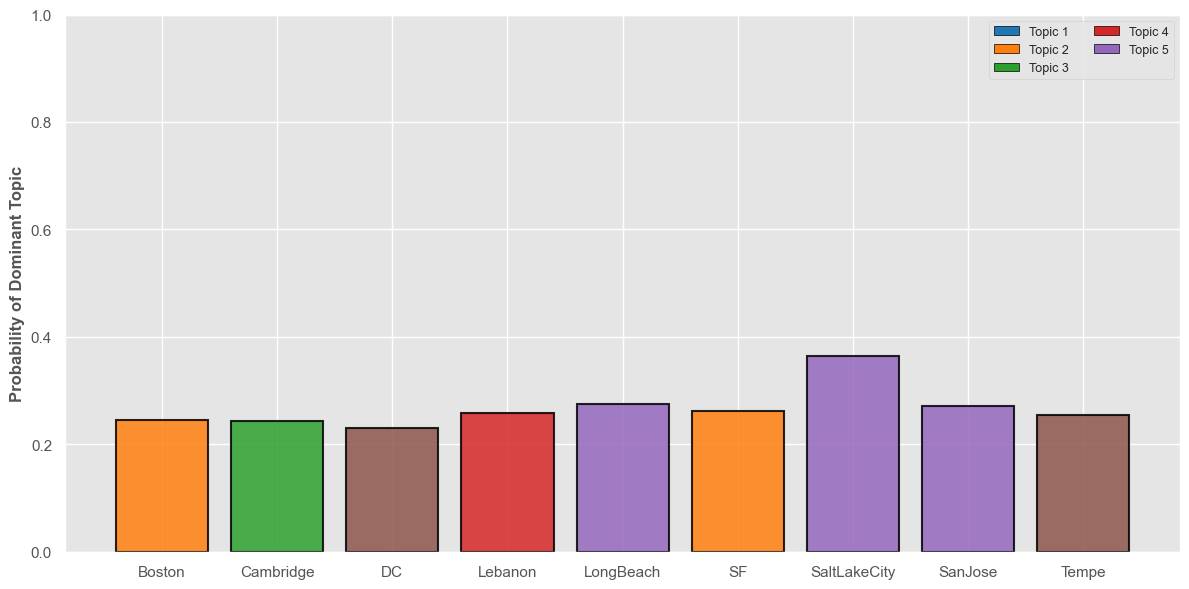


Dominant Topics Summary:
       Document Dominant Topic  Probability
0        Boston        Topic 1        0.245
1     Cambridge        Topic 2        0.243
2            DC        Topic 5        0.230
3       Lebanon        Topic 3        0.258
4     LongBeach        Topic 4        0.275
5            SF        Topic 1        0.262
6  SaltLakeCity        Topic 4        0.365
7       SanJose        Topic 4        0.272
8         Tempe        Topic 5        0.255


In [32]:
# Bar chart showing which topic is most prominent in each document

# Get dominant topic for each document
doc_dominant_topics = doc_topic_agg.idxmax(axis=1)
doc_dominant_probs = doc_topic_agg.max(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

# Use first 6 tab10 colors (blue through brown) and repeat if needed

bars = ax.bar(
    range(len(doc_topic_agg)),
    doc_dominant_probs,
    color=[plt.get_cmap('tab10').colors[int(doc_dominant_topics.str.extract(r'(\d+)')[0].iloc[i])] for i in range(len(doc_topic_agg))],
    edgecolor='black',
    linewidth=1.5,
    alpha=0.85
)

# Add legend for topics
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=plt.get_cmap('tab10').colors[i % 10], edgecolor='black', label=f'Topic {i +1}') 
                   for i in range(optimal_n_topics)]
ax.legend(handles=legend_elements, loc='upper right', ncol=2, fontsize=9)

ax.set_xticks(range(len(doc_topic_agg)))

ax.set_xticklabels(doc_topic_agg.index, rotation=0)

ax.set_ylabel('Probability of Dominant Topic', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../visualizations/doc_dominant_topics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDominant Topics Summary:")
print(pd.DataFrame({
    'Document': doc_topic_agg.index,
    'Dominant Topic': doc_dominant_topics.values,
    'Probability': doc_dominant_probs.values.round(3)
}))